# Morar em uma cidade grande te da mais chances de tirar uma nota maior no ENEM?

Como um brasileirinho do interior de São Paulo sempre me perguntei "será que se tivesse nascido e morado em uma cidade maior eu teria mais oportunidades, um salário maior, uma nota maior no ENEM?". Durante essa semana da imersão dados, fiquei me perguntando se usando data science e os dados do ENEM 2019 não seria capaz de responder a essa pegunta (pelo menos em relação à prova do ENEM).

A minha hipótese, é de que, morando em uma cidade maior ficaria mais fácil ter acesso à escolas melhores (ou pelo menos mais opções) e, assim, sua nota no ENEM vai ser melhor. Claro, estou assumindo que escolas melhores estão mais presente em cidades maiores, o que faz sentido já que fica mais fácil escolher melhores professores (e até melhores alunos) em uma população maior.

Pra isso, precisei buscar um tabela com a população de cada munícipio do Brasil e explorar essa hipótese e mais algumas que surgiram no caminho.

### Buscando a população de cada municipio do Brasil

In [1]:
# Bibliotecas necessárias para pegar as informações da wikipedia
from bs4 import BeautifulSoup
import requests
import pandas as pd

# Página da wiki com os dados de opopulação de todos os munícipios do Brasil
wiki_url = 'https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o_(2019)'

# Fazendo o resquest da página
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text,'html.parser')

# Extraindo apenas a tabela
tabela_html = soup.find('table')

# Transformando a tabela em um data frame
tabela = pd.read_html(str(tabela_html))
dados_cidades = tabela[0]

# Mostrando as 10 primeiras linhas da tabela
dados_cidades.head(10)

,Posição,Código IBGE,Município,Unidade federativa,População
0,1º,3550308,São Paulo,São Paulo,12 252 023
1,2º,3304557,Rio de Janeiro,Rio de Janeiro,6 718 903
2,3º,5300108,Brasília,Distrito Federal,3 015 268
3,4º,2927408,Salvador,Bahia,2 872 347
4,5º,2304400,Fortaleza,Ceará,2 669 342
5,6º,3106200,Belo Horizonte,Minas Gerais,2 512 070
6,7º,1302603,Manaus,Amazonas,2 182 763
7,8º,4106902,Curitiba,Paraná,1 933 105
8,9º,2611606,Recife,Pernambuco,1 645 727
9,10º,5208707,Goiânia,Goiás,1 516 113


### Importando os dados do ENEM

In [2]:
import pandas as pd

fonte = "https://github.com/alura-cursos/imersao-dados-2-2020/blob/master/MICRODADOS_ENEM_2019_SAMPLE_43278.csv?raw=true"

dados_enem = pd.read_csv(fonte)
dados_enem.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004661,2019,1506138,Redenção,15,PA,17,M,1,3,...,A,A,A,A,B,A,C,A,B,B
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,...,A,A,A,B,A,A,B,A,A,B
2,190001004722,2019,1501402,Belém,15,PA,35,F,2,1,...,A,A,A,B,A,B,B,A,A,B
3,190001004735,2019,1507300,São Félix do Xingu,15,PA,23,F,1,3,...,A,A,A,B,A,A,B,A,A,B
4,190001004776,2019,1500800,Ananindeua,15,PA,16,F,1,3,...,A,A,A,B,A,A,D,A,A,B


### Pergunta 1: temos todas as cidades na amostra?

Uma primeira pergunta que me veio a cabeça foi, será que na nossa amostra dos dados do ENEM temos todas cidades que tem na tabela que peguei da wiki? Provavelmente não, já que quanto menos pessoas uma dada população tem, menos a chance de ser selecionada uma pessoa dessa cidade fazendo uma amostra aleatória de todo o universo de pessoas do Brasil que fizeram o ENEM em 2019.

In [3]:
# Numero de municipio da 
n_muni_amostra = len(dados_enem["CO_MUNICIPIO_RESIDENCIA"].unique())
print("Número de municípios da amostra dos dados do ENEM 2019:",n_muni_amostra)

n_muni_brasil = len(dados_cidades['Código IBGE'].unique())
print("Número de municípios do Brasil:",n_muni_brasil)

print("Temos percentualmente: ",n_muni_amostra/n_muni_brasil)

Número de municípios da amostra dos dados do ENEM 2019: 5133
Número de municípios do Brasil: 5570
Temos percentualmente:  0.9215439856373429


Minha intuição estava correta, mas a porcentagem é bem alta. Porém, acredito que isso possa afetar minha análise, já que é mais provável que as cidades que não aparecem na amostra são justamente aquelas com menor população.

Perceba que eu usei o código da cidade ao invés do nome da cidade, isso é pq algumas cidades tem nome iguais mas são de estados diferentes

### Pegunta 2: Consigo ver alguma relação usando um scatter plot?

Primeiro, preciso verificar a cidade de cada aluno e consultar qual a população dela, guardando essa informações em uma nova coloca do dataframe dados_enem que vou chamar de "NU_POPULACAO_MUNICIPIO_RESIDENCIA"

In [4]:
import numpy as np

# Alocação de memória
dados_enem["NU_POPULACAO_MUNICIPIO_RESIDENCIA"] = np.zeros(len(dados_enem))

# Cidades que estão na amostra do ENEM
cidades_da_amostra = dados_enem["CO_MUNICIPIO_RESIDENCIA"].unique()

# Laço para preencher a coluna de população
for cidade in cidades_da_amostra:
    
    # Corrigindo os valores das populações (formato veio esquisito)
    populacao_zuado = dados_cidades[dados_cidades["Código IBGE"] == cidade]['População'].values[0]
    populacao_str = populacao_zuado.replace('\xa0','')
    populacao = int(populacao_str)

    # Preenchedo a coluna populacao para cada cidade
    dados_enem.loc[dados_enem["CO_MUNICIPIO_RESIDENCIA"] == cidade,
                   "NU_POPULACAO_MUNICIPIO_RESIDENCIA"] = populacao

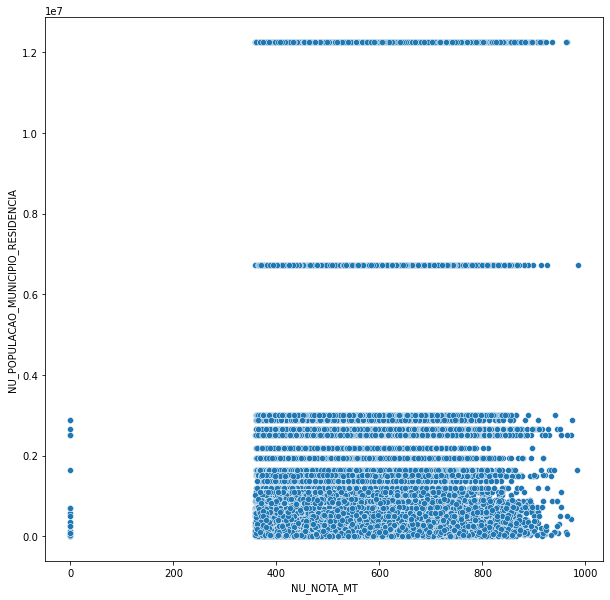

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.scatterplot(data = dados_enem, x = 'NU_NOTA_MT', y = 'NU_POPULACAO_MUNICIPIO_RESIDENCIA')

Olhando pro gráfico acima, é muito dificil tirar qualquer conclusão, os pontos estão muito juntos e não há nenhum agrupando muito evidente.

Assim, acho que seria melhor olhar a distribuição de acordo com o número de habitantes de cada cidade, mas isso geraria um histograma para cada cidade. Dessa forma, acredito que a melhor forma de analisar seja classificando as cidades em grandes ou pequenas. Pra isso, vou usar a mediana.

### Pergunta 3: Será que é possível extrair alguma conclusão olhando para as distribuições das notas de pessoas de cidades pequenas e de cidade grandes?

Primeiro vou precisar calcular a mediana das populações usando a lista de todas as cidades

In [6]:
# Convertendo o valor da população para string
dados_pop_nome = dados_cidades[['População','Código IBGE']].astype(str).applymap(lambda x: str(x).replace('\xa0',''))

# Calculando a mediana
dados_pop_nome['População'].median()

11631.0

In [7]:
# 0: municipio com população menor ou igual a mediana
# 1: município com população maior a mediana

# Alocação de memória
dados_enem["TP_POPULACAO_MUNICIPIO_GRANDE"] = np.zeros(len(dados_enem))

for cidade in cidades_da_amostra:
    
    # Corrigindo os valores das populações (formato veio esquisito)
    populacao = int(dados_pop_nome[dados_pop_nome["Código IBGE"] == str(cidade)]['População'].values)

    # Preenchedo a coluna cidade grande para cada cidade
    if populacao > dados_pop_nome['População'].median():
        dados_enem.loc[dados_enem["CO_MUNICIPIO_RESIDENCIA"] == cidade,
                   "TP_POPULACAO_MUNICIPIO_GRANDE"] = 1

dados_enem["TP_POPULACAO_MUNICIPIO_GRANDE"]

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
127375    1.0
127376    1.0
127377    1.0
127378    1.0
127379    1.0
Name: TP_POPULACAO_MUNICIPIO_GRANDE, Length: 127380, dtype: float64

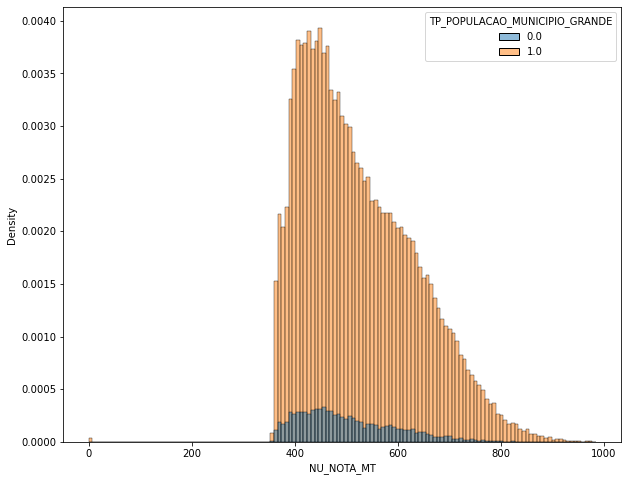

In [32]:
# Plotando o histograma
plt.figure(figsize=(10,8))
sns.histplot(dados_enem,x = "NU_NOTA_MT",hue='TP_POPULACAO_MUNICIPIO_GRANDE',stat='density',
            common_norm=True)

Olhando para o pico das duas curvas acima, podemos ver que a curva azul (cidade menores) tem uma maior concentração de notas na direção dos 400 pontos, enquanto que a curva laranja (cidades grandes) tem a notas mais concentradas para a direta. 

Podemos checar isso calculando as medias, medianas e modas

In [30]:
nota_mt_maiores = dados_enem.query('TP_POPULACAO_MUNICIPIO_GRANDE == 1')['NU_NOTA_MT']
nota_mt_menores = dados_enem.query('TP_POPULACAO_MUNICIPIO_GRANDE == 0')['NU_NOTA_MT']

# Médias
print('Médias')
print('Cidades maiores:',nota_mt_maiores.mean())
print('Cidades menores:',nota_mt_menores.mean())

# Medianas
print('\nMedianas')
print('Cidades maiores:',nota_mt_maiores.median())
print('Cidades menores:',nota_mt_menores.median())

# Modas
print('\nModas')
print('Cidades maiores:',nota_mt_maiores.median())
print('Cidades menores:',nota_mt_menores.median())

Médias
Cidades maiores: 525.068418325046
Cidades menores: 501.3825345933172

Medianas
Cidades maiores: 503.2
Cidades menores: 482.0

Modas
Cidades maiores: 503.2
Cidades menores: 482.0


Como podemos ver, os três valores são ligeiramente maiores para as cidades maiores. Claro, isso pode ser explicado um pouco pela amostragem que favoreceu um pouco mais as cidades maiores, mas já é alguma coisa.

Uma outra coisa que pode ser vista nos histogramas é que a curva das cidades menores parece ser "mais aberta" ou ter a cauda mais curta em relação ao histograma dascidade grandes. Para medir isso, vou usar uma medida chamada curtose (kurtosis) que mede exatamente o quanto uma distribuição é mais aberta ou fechada (https://en.wikipedia.org/wiki/Kurtosis)

In [25]:
print('Cidades maiores:',dados_enem.query('TP_POPULACAO_MUNICIPIO_GRANDE == 1')['NU_NOTA_MT'].kurtosis())
print('Cidades menores:',dados_enem.query('TP_POPULACAO_MUNICIPIO_GRANDE == 0')['NU_NOTA_MT'].kurtosis())

Cidades maiores: -0.04301728565393681
Cidades menores: 0.14271356629627263


O valor da curtose das cidades maiores é bem menor que o das cidade menores e chega até ser negativa, podendo ser classificada como 'Platykurtic'.

Em geral, os testes de hipótese para confirmar se as médias são de fato diferentes como o ANOVA [1] assumem normalidade da distribuição e variância igual das duas amostras. Além disso, distribuições do tipo 'Platykurtic' tem efeito grande quando o tamanho das amostras é muito diferente (o que é o caso aqui)[2]

Portanto, vou usar o teste de Welch [3], mas também comprar o ANOVA.

[1] https://en.wikipedia.org/wiki/Analysis_of_variance
[2] https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-3.php#:~:text=As%20regards%20the%20normality%20of,the%20Type%20I%20error%20rate.&text=Both%20the%20Welch%20and%20Brown,ANOVA%20using%20SPSS%20Statistics%20guide)
[3] https://en.wikipedia.org/wiki/Welch%27s_t-test

In [26]:
# Testes estatíticos para verificar se de fato as distribuições são de populações diferentes

from scipy.stats import ttest_ind,f_oneway

# Teste ANOVA: \assume curva normal, variancia é igual, mas aceita um pouco de desvio dessas condições
print(f_oneway(nota_mt_maiores.dropna(),nota_mt_menores.dropna()))

# Teste de Welch: permite que a a variancia não seja normal e diferentes tamanhos de amostra
print(ttest_ind(nota_mt_maiores.dropna(),nota_mt_menores.dropna()))

F_onewayResult(statistic=260.68395437861307, pvalue=1.4636436714710302e-58)
Ttest_indResult(statistic=16.145710092114705, pvalue=1.4636436714015657e-58)


O que os testes confirmam é que as notas dos alunos de cidades maiores parecem ter sido coletadas de uma população diferente, ou seja, a diferença das médias é de fato significativa, pelo menos para a prova de matemática.

Eu consigo até imaginar a voz do Paulo Silveira falando "ta, mas o que eu faço com isso? tenho que mudar os alunos do Brasil todo pra cidades maiores que 100mil habitantes pra aumentar a média da nota do ENEM?"

É claro que não.

Acho que o que fica evidente aqui é que, provavelmente, cidades menores, em geral, tem escolas de menor qualidade, menos infraestrutura e que isso é uma desigualdade que só pode ser resolvida com muitos anos de mais investimento nessas escolas. É claro que os melhores professores e escolas vão provavelmente se concentrar em cidades maiores ainda, por uma questão estatítica mesmo, devido a maior quantidade de pessoas, fica mais fácil ter um grupo maior de alunos que vão tirar notas mais altas.